## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import numpy as np
import os
import h5py
import keras
import itertools

# 神經網絡正規化
from keras.regularizers import l1, l2, l1_l2 
# 神經網絡隨機拋棄、批次標準化、激活函數
from keras.layers import Dense, Dropout, BatchNormalization, Activation 
# Early Stopping
from keras.callbacks import EarlyStopping
# 自動存取目前模型的最佳權重
from keras.callbacks import ModelCheckpoint
# Reduce Learning Rate
from keras.callbacks import ReduceLROnPlateau
# 訓練模型時，利用 callback 紀錄訓練過程
from keras.callbacks import Callback


import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline



# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data( )

170500096/170498071 [==============================] - 4s 0us/step


# 資料前處理 - 標準化 及 獨熱編碼(OneHot Encoding)

In [0]:
def preproc_x( x, flatten = True ) :
    x = x / 255.
    if flatten:
        x = x.reshape( ( len(x), -1 ) )
    return x

def preproc_y( y, num_classes = 10 ) :
    if y.shape[ -1 ] == 1:
        y = keras.utils.to_categorical( y, num_classes )
    return y  

In [0]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 - Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

# 建立神經網絡模型

In [5]:
def build_mlp( input_shape, output_units = 10, num_neurons = [ 512, 256, 128 ], pre_activate = False ) : 
    
    input_layer = keras.layers.Input( input_shape )
    
    for i, n_units in enumerate( num_neurons ) : 
        if i == 0 :
            x = keras.layers.Dense( units = n_units, 
                                             activation = "relu", 
                                             name = "Hidden_Layer_" + str( i+1 ) )( input_layer )  
            
            if pre_activate :
                # Batch Normalization Layer before Activation Function 
                x = BatchNormalization( name = "BN_Layer_" + str( i+1 ) )( x )
                x = Activation( 'relu', name = 'Activation_' + str( i+1 ) )( x )
            else :
                x = Activation( 'relu', name = 'Activation_' + str( i+1 ) )( x )
                x = BatchNormalization( name = "BN_Layer_" + str( i+1 ) )( x )
            
            
            
        else :
            x = keras.layers.Dense( units = n_units, 
                                             activation = "relu",  
                                             name = "Hidden_Layer_" + str( i+1 ) )( x )  
            
            if pre_activate :
                # Batch Normalization Layer before Activation Function
                x = BatchNormalization( name = "BN_Layer_" + str( i+1 ) )( x )
                x = Activation( 'relu', name = 'Activation_' + str( i+1 ) )( x )
            else :
                x = Activation( 'relu', name = 'Activation_' + str( i+1 ) )( x )
                x = BatchNormalization( name = "BN_Layer_" + str( i+1 ) )( x )
                          
              
    output_layer = keras.layers.Dense( units = output_units, 
                                                     activation = 'softmax', 
                                                     name = 'Output_Layer' )( x )
    
    model = keras.models.Model( inputs = [ input_layer ], outputs = [ output_layer ] )
    return model

model = build_mlp( input_shape = x_train.shape[ 1: ] ) 
model.summary( )

W0723 15:27:02.473859 140538090633088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 15:27:02.514605 140538090633088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 15:27:02.522536 140538090633088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 15:27:02.641864 140538090633088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
Activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
BN_Layer_1 (BatchNormalizati (None, 512)               2048      
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
Activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
BN_Layer_2 (BatchNormalizati (None, 256)               1024      
__________

# 設定超參數

In [0]:
EPOCHS = 100
BATCH_SIZE = 1024

PRE_ACTIVATE = True       # Batch Normalization Layer before activation function 

LEARNING_RATE = [ 1e-3 ]  # for optimizer
MOMENTUM = 0.95           # for optimizer 

# PATIENCE = [ 10, 25 ]     # for early stopping
REDUCE_LR_FACTOR = [ 0.25 ] # for reduce learning rate
REDUCE_LR_PATIENCE = [ 5 ]  # for reduce learning rate

# 優化器(Optimizer)

In [0]:
SGD = keras.optimizers.SGD( lr = LEARNING_RATE, 
                                          momentum = MOMENTUM, 
                                          nesterov = True
                                          )

Optimizers = [ 'SGD' ]

# Callbacks 紀錄或介入調整模型訓練過程

In [0]:
# 紀錄 True Positive 與 True Negative 數量
class Record_tp_tn( Callback ) :

    def on_train_begin( self, epoch, logs = { } ) :   # 在訓練開始前
        logs = logs or { }
        record_items = [ 'val_auc', 'true_positives', 'true_negatives', 'val_fp', 'val_fn', 'val_tp', 'val_tn' ]
        for i in record_items :
            if i not in self.params[ 'metrics' ] :
                self.params[ 'metrics' ].append( i )
                
    def on_epoch_end( self, epoch, logs = { }, thres = 0.5 ) :  # 在每個 Epoch 訓練完成後
        logs = logs or { }
        y_true = self.validation_data[1].argmax( axis = 1 )
        y_pred = self.model.predict( self.validation_data[0] )
        y_pred = ( y_pred[ :, 1 ] >= thres ) * 1
        True_Positives = np.sum( np.logical_and( y_pred == 1, y_true == 1 ) )
        True_Negatives = np.sum( np.logical_and( y_pred == 0, y_true == 0 ) )
        logs[ 'true_positives' ] = True_Positives
        logs[ 'true_negatives' ] = True_Negatives
        
Record_TPTN = Record_tp_tn( )

# 訓練模型

In [9]:
results = { }

"""
建立訓練與實驗迴圈並蒐集資料
"""
for i, ( lr, optim, reduce_factor, reduce_patience ) in enumerate( itertools.product( LEARNING_RATE, Optimizers, REDUCE_LR_FACTOR, REDUCE_LR_PATIENCE ) ) :

    keras.backend.clear_session( )    # 清掉舊的 Graph 
    
    print( 'learning_rate: %.2f, reduce_factor: %.2f, reduce_patience: %i' % ( i, reduce_factor, reduce_patience ) )
    
    # Early Stopping
    #EARLY_STOP = EarlyStopping( monitor = "val_loss", 
    #                                            patience = PATIENCE,  # 容忍訓練無再改善時的 EPOCHS 次數
    #                                            verbose = 1
    #                                             )
    
    # Model Check Point( 自動存取目前模型的最佳權重 )
    #ModelCheckPoint = ModelCheckpoint( filepath = './weights.best.h5' ,
    #                                                       monitor = 'val_acc', 
    #                                                       save_best_only = True
    #                                                       )
    
    model = build_mlp( input_shape = x_train.shape[ 1: ], pre_activate = PRE_ACTIVATE )
    model.summary( )
    

    
    # 執行神經網絡
    model.compile( loss = 'categorical_crossentropy', 
                          optimizer = optim, 
                          metrics = [ 'accuracy' ] 
                          )
    
    # Reduce Learning Rate ( when a metric has stopped improving! )
    Reduce_LR = ReduceLROnPlateau( factor = reduce_factor, # new_lr = lr * factor
                                                      min_lr = 1e-12,             # lower bound on lr
                                                      monitor = 'val_loss', 
                                                      patience = reduce_patience,  # number of epochs with no improvement after which lr will be reduced
                                                      verbose = 1
                                                      )
    
    model.fit( x_train, y_train, 
                  epochs = EPOCHS,     
                  validation_data = ( x_test, y_test ), 
                  #validation_split = 0.2,  # Fraction of the training data to be used as validation data.
                  batch_size = BATCH_SIZE, 
                  #callbacks = [ EARLY_STOP ],
                  callbacks = [ Reduce_LR, Record_TPTN ],
                  #callbacks = [rec_tptn]
                  shuffle = True
                  )
    
    # Collect results
    train_loss = model.history.history[ 'loss' ]
    valid_loss = model.history.history[ 'val_loss' ]
    train_acc = model.history.history[ 'acc' ]
    valid_acc = model.history.history[ 'val_acc' ]
    
    exp_name_tag = 'Learning Rate =' + str( lr ) + ', Optimizer:' + str( optim ) + ', Reduce Factor =' + str( reduce_factor ) + ', Reduce Patience =' + str( reduce_patience )
    results[ exp_name_tag ] = { 'Train Loss': train_loss,
                                           'Valid Loss': valid_loss,
                                           'Train Acc': train_acc,
                                           'Valid Acc': valid_acc
                                           }    

W0723 15:27:03.089784 140538090633088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



learning_rate: 0.00, reduce_factor: 0.25, reduce_patience: 5


W0723 15:27:03.421171 140538090633088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 15:27:03.561226 140538090633088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
BN_Layer_1 (BatchNormalizati (None, 512)               2048      
_________________________________________________________________
Activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
BN_Layer_2 (BatchNormalizati (None, 256)               1024      
_________________________________________________________________
Activation_2 (Activation)    (None, 256)               0         
__________

In [0]:
"""
將 True Positives/True Negatives 從訓練完的模型中取出
"""
valid_tp = model.history.history[ 'true_positives' ]  
valid_tn = model.history.history[ 'true_negatives' ]

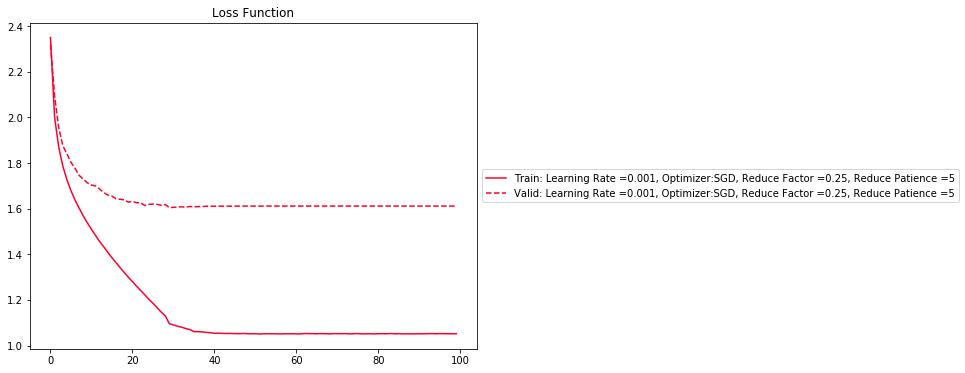

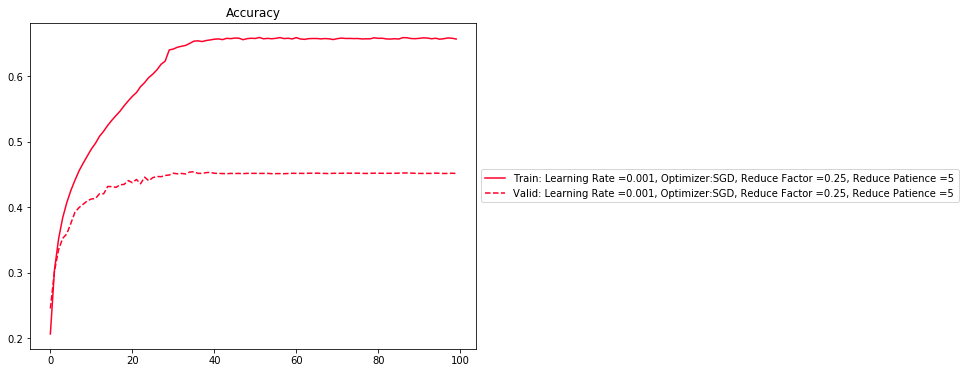

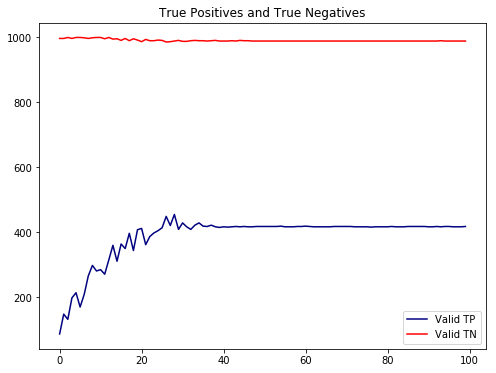

In [14]:
NUM_COLORS = len( results.keys( ) )
cm = plt.get_cmap( 'gist_rainbow' )
cNorm  = colors.Normalize( vmin = 0, vmax = NUM_COLORS - 1 )
scalarMap = mplcm.ScalarMappable( norm = cNorm, cmap = cm )
color_bar = [ scalarMap.to_rgba( i ) for i in range( NUM_COLORS ) ]

plt.figure( figsize = ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot( range( len( results[cond]['Train Loss']) ), results[cond]['Train Loss'], '-', label = 'Train: ' + cond, color = color_bar[i] )
    plt.plot( range( len( results[cond]['Valid Loss']) ), results[cond]['Valid Loss'], '--', label = 'Valid: ' + cond, color = color_bar[i] )
plt.title( 'Loss Function' )
plt.legend( loc = 'center left', bbox_to_anchor = ( 1, 0.5 ) )
plt.show( )

plt.figure( figsize= ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot( range( len( results[cond]['Train Acc']) ), results[cond]['Train Acc'], '-', label = 'Train: ' + cond, color = color_bar[i] )
    plt.plot( range( len( results[cond]['Valid Acc']) ), results[cond]['Valid Acc'], '--', label = 'Valid: ' + cond, color = color_bar[i] )
plt.title( 'Accuracy' )
plt.legend( loc = 'center left', bbox_to_anchor = ( 1, 0.5 ) )
plt.show( )

plt.figure( figsize = ( 8, 6 ) )
plt.plot( range( len( valid_tp ) ), valid_tp, label = 'Valid TP', color = 'navy' )
plt.plot( range( len( valid_tn ) ), valid_tn, label = 'Valid TN', color = 'red' )
plt.title( 'True Positives and True Negatives' )
plt.legend( )
plt.show( )